In [ ]:
import pandas as pd
import re

In [ ]:
df = pd.read_excel('data_training (1).xlsx')
df

,Deal Name,Stage,Label,Type Activity,Note
0,Translation SM NETA X,DEAL,DEAL,0,"deal harga, dibayar"
1,ERP fase 1,DEAL,DEAL,0,"project sudah selesai , menunggu pembayaran"
2,Pak Ardianta By Ncc -ARDCA MADAM,PAID,DEAL,0,Deal cocok untuk MADAM
3,ERP fase 2,DEAL,DEAL,0,"Deal harga, dibayar"
4,\nAdvanced Training Mazda CX60,DEAL,DEAL,0,"Deal harga, dibayar"
...,...,...,...,...,...
79,Sales Training (Volvo Cars),INITIAL MEETING/CALL,COLD,TASK,MoM Kris dengan Pak Toto_Volvo Cars Indonesia....
80,Pembuatan Logo - ERA JAYA,INITIAL MEETING/CALL,HOT,TASK,"Sudah kirim quotation , sedang di review"
81,Software Seni (Bu Nina) - Website E Commerce,NEGOTIATION,WARM,TASK,"Sudah meeting dengan tim , kebutuhan website d..."
82,Bunda BC - Optimisasi Ads di Marketplace,INITIAL MEETING/CALL,WARM,TASK,Mau meeting di tanggal 08 Juni 2024 sama mas G...


In [ ]:
df.drop('Stage', axis=1, inplace=True)

In [ ]:
# Define bobot untuk Type Activity
activity_weights = {
    'TASK': 1,
    'CALL': 2,
    'DEADLINE': 1,
    'EMAIL': 1,
    'MEETING': 3
}

note_weight = 1

# Add bobot berdasarkan jenis aktivitas dan notes
def calculate_activity_score(row):
    score = activity_weights.get(row['Type Activity'], 0)
    return score

df['Activity Score'] = df.apply(calculate_activity_score, axis=1)

In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    text = str(text)
    text = re.sub(r'\d+', ' ', text)
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['Note'] = df['Note'].apply(clean_text)

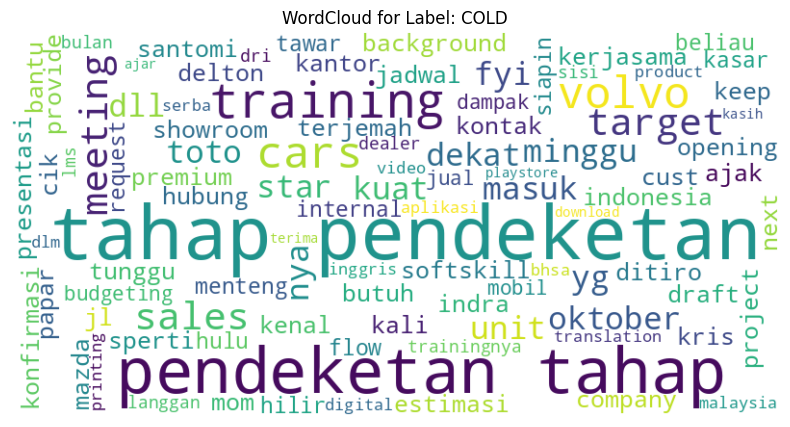

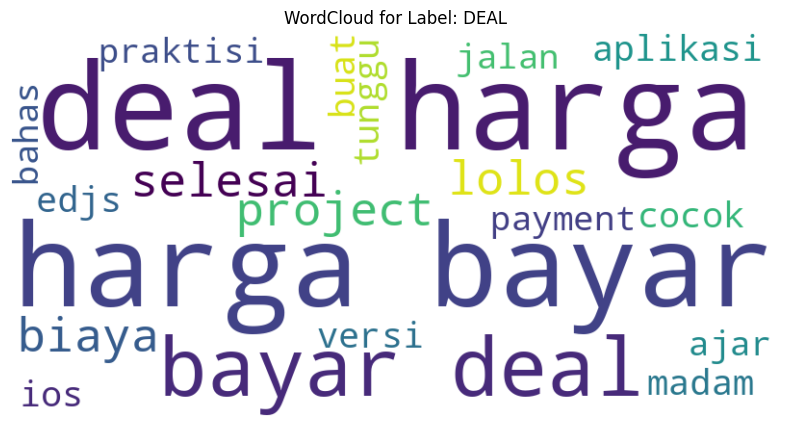

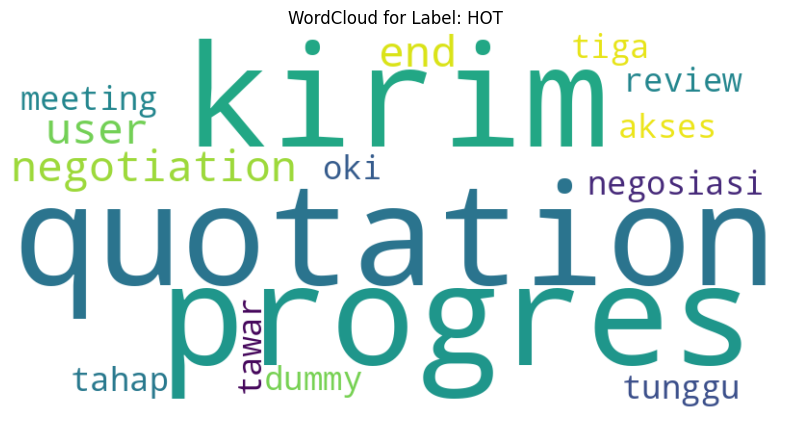

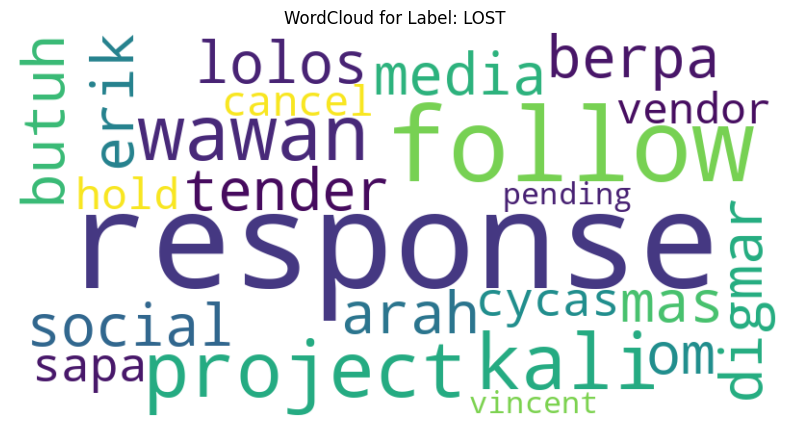

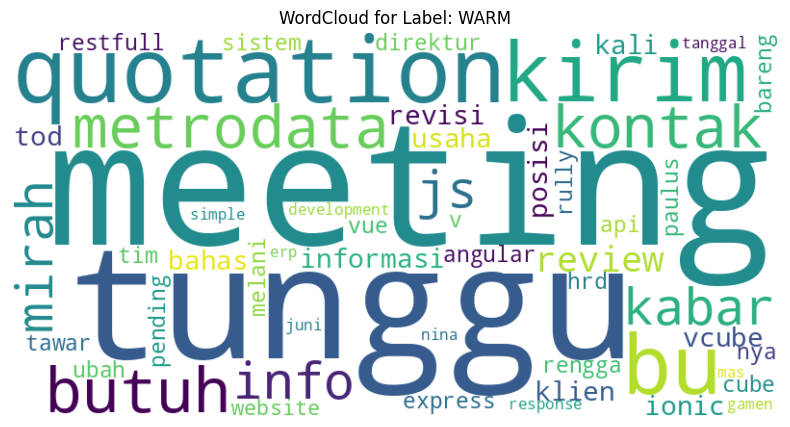

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Kelompokkan data berdasarkan kolom 'Label'
grouped = df.groupby('Label')

# Loop melalui setiap label dan tampilkan WordCloud
for label, group in grouped:
    text = ' '.join(group['Note'])  # Gabungkan semua teks dari kolom 'Note' untuk label tersebut

    # Buat WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Label: {label}")
    plt.show()


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Note'])
sequences = tokenizer.texts_to_sequences(df['Note'])

# Padding sequences
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
import joblib
joblib.dump(tokenizer, 'token.pkl')

['token.pkl']

### Split data

In [ ]:
import numpy as np
X = np.hstack((df[['Activity Score']].values, padded_sequences))
y = df['Label'].replace({'LOST': 4, 'COLD': 0, 'WARM': 1, 'HOT': 2, 'DEAL': 3}).values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_train, y_train = X_resampled, y_resampled

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[3 1 1 0 0]
 [0 3 0 0 0]
 [0 0 0 0 0]
 [0 0 0 5 0]
 [0 1 0 2 1]]
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.60      1.00      0.75         3
           2       0.00      0.00      0.00         0
           3       0.71      1.00      0.83         5
           4       1.00      0.25      0.40         4

    accuracy                           0.71        17
   macro avg       0.66      0.57      0.55        17
weighted avg       0.85      0.71      0.69        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import joblib
joblib.dump(model, 'modelRF.pkl')

['modelRF.pkl']

### Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=100)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[3 0 0 2 0]
 [1 1 1 0 0]
 [0 0 0 0 0]
 [0 0 0 5 0]
 [0 1 0 2 1]]
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         0
           3       0.56      1.00      0.71         5
           4       1.00      0.25      0.40         4

    accuracy                           0.59        17
   macro avg       0.56      0.44      0.44        17
weighted avg       0.71      0.59      0.57        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=100)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[3 2 0 0]
 [1 2 0 0]
 [0 1 0 4]
 [1 2 0 1]]
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.29      0.67      0.40         3
           3       0.00      0.00      0.00         5
           4       0.20      0.25      0.22         4

    accuracy                           0.35        17
   macro avg       0.27      0.38      0.31        17
weighted avg       0.27      0.35      0.30        17



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## NN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          52,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,029 (879.02 KB)

 Trainable params: 225,029 (879.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.1258 - loss: 3.1373 - val_accuracy: 0.4118 - val_loss: 2.6697
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4650 - loss: 1.6393 - val_accuracy: 0.4118 - val_loss: 1.8573
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4885 - loss: 1.3957 - val_accuracy: 0.2353 - val_loss: 1.9480
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3965 - loss: 1.4859 - val_accuracy: 0.4118 - val_loss: 1.8175
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5041 - loss: 1.3358 - val_accuracy: 0.4118 - val_loss: 1.7053
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5190 - loss: 1.2533 - val_accuracy: 0.6471 - val_loss: 1.6847
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6035 - loss: 1.2076 - val_accuracy: 0.7059 - val_loss: 1.5746
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7712 - loss: 1.1769 - val_accuracy: 0.4706 - val_loss:

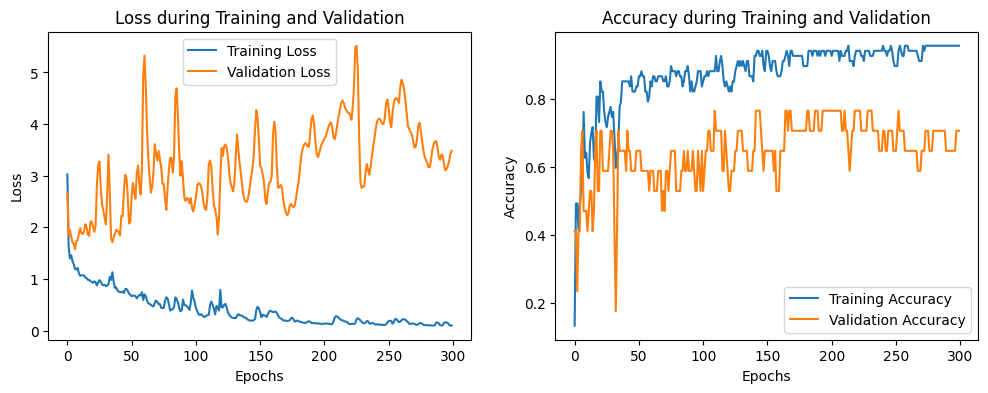

In [ ]:
# Loss plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


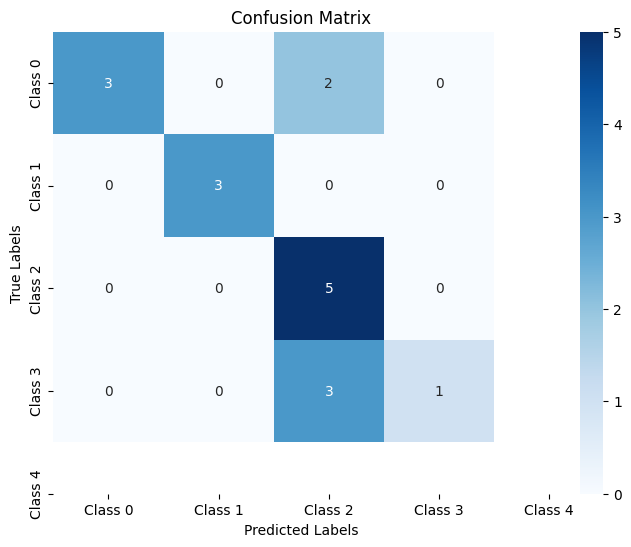

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3 0 2 0]
 [0 3 0 0]
 [0 0 5 0]
 [0 0 3 1]]
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         3
           3       0.50      1.00      0.67         5
           4       1.00      0.25      0.40         4

    accuracy                           0.71        17
   macro avg       0.88      0.71      0.70        17
weighted avg       0.85      0.71      0.69        17



### Load Model

In [ ]:
import tensorflow as tf
loaded_model = joblib.load('modelRF.pkl')

In [ ]:
predictions = loaded_model.predict(X_test)
# predictions = np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7058823529411765
